Building an Image Classifier model from scratch

#Setup

In [2]:
import kagglehub
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical, load_img, img_to_array

import os
import shutil
from sklearn.model_selection import train_test_split


path = r".\kagglehub\datasets\andrewmvd\medical-mnist\versions\1"

print(path)
# checking if the file location is recognized
print(os.path.isdir(path))

c:\Users\seaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


.\kagglehub\datasets\andrewmvd\medical-mnist\versions\1
True


# Load a dataset

In [3]:
# Generating and preparing the dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)


# taking small batch to keep as validation data
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    path,
    target_size=(64, 64),  # images should be 64x64 by default
    color_mode="grayscale",  # leave it grayscale
    batch_size=32,
    class_mode='categorical',
    # for multi-class classification, didn't want to copy the dir like I had in earlier versions
    subset="training")


# validation data
validation_generator = validation_datagen.flow_from_directory(
    path,
    target_size=(64, 64),
    color_mode="grayscale",
    batch_size=32,
    class_mode='categorical',
    # multi-classification, seperating data while running rather than before
    subset="validation")

Found 58954 images belonging to 6 classes.
Found 11790 images belonging to 6 classes.


# Build a neural network model

In [4]:

# define model using Sequential API
model = Sequential([
    # first convolutional layer

    # image shape is 64x64 with grayscale (1)
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),


    MaxPooling2D((2, 2)),


    # apply 32 filters of size 3x3 to the input

    Conv2D(64, (3, 3), activation='relu'),


    MaxPooling2D((2, 2)),


    # second convolutional layer

    Conv2D(128, (3, 3), activation='relu'),

    # second convolutional layer, further reduces spatial dimensions
    MaxPooling2D((2, 2)),


    Flatten(),  # flatten from 3D feature maps to a 1D vector

    # Dense layer with 128 neurons, relu introduces non-linearity
    Dense(128, activation='relu'),


    Dropout(0.5),


    Dense(6, activation='softmax')  # Output layer with 6 classes


])

c:\Users\seaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,398 (2.61 MB)

 Trainable params: 683,398 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

#compiling the model:


In [6]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [7]:
"""# check the output of flow_from_directory
print(f"Train generator classes: {train_generator.class_indices}")
print(f"Validation generator classes: {validation_generator.class_indices}")

# check batch sizes and data shapes
for batch, labels in train_generator:
    print(f"Batch shape: {batch.shape}, Label shape: {labels.shape}")
    break  # just inspect the first batch"""

'# check the output of flow_from_directory\nprint(f"Train generator classes: {train_generator.class_indices}")\nprint(f"Validation generator classes: {validation_generator.class_indices}")\n\n# check batch sizes and data shapes\nfor batch, labels in train_generator:\n    print(f"Batch shape: {batch.shape}, Label shape: {labels.shape}")\n    break  # just inspect the first batch'

# training neural network model:


In [8]:
#training time 
history = model.fit(train_generator, epochs=5, validation_data = validation_generator, shuffle=True)

c:\Users\seaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 151s 81ms/step - accuracy: 0.8831 - loss: 0.3060 - val_accuracy: 0.9982 - val_loss: 0.0082
Epoch 2/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 62s 33ms/step - accuracy: 0.9925 - loss: 0.0279 - val_accuracy: 0.9988 - val_loss: 0.0054
Epoch 3/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 62s 34ms/step - accuracy: 0.9892 - loss: 0.0370 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 4/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 62s 33ms/step - accuracy: 0.9951 - loss: 0.0157 - val_accuracy: 0.9998 - val_loss: 0.0010
Epoch 5/5
1843/1843 ━━━━━━━━━━━━━━━━━━━━ 61s 33ms/step - accuracy: 0.9864 - loss: 0.0538 - val_accuracy: 0.9997 - val_loss: 0.0013


#Evaluation



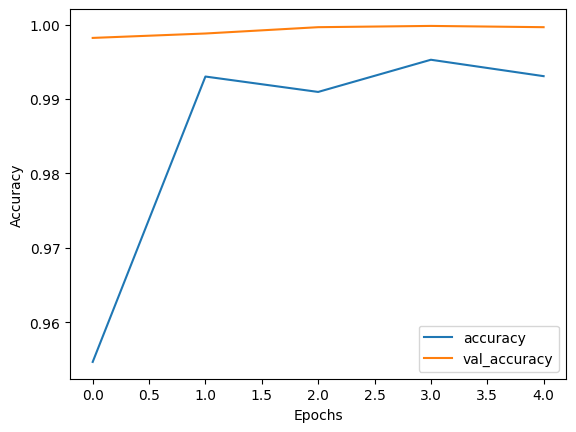

369/369 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9997 - loss: 0.0017
Test Accuracy: 0.9996607303619385


In [ ]:
# plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the model
model.save('image_classifier_model.h5')

# Test the model
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test Accuracy: {test_accuracy}')


In [10]:
# Checking if value exists
"""print(val_dir)
print(os.path.exists(val_dir + r"\HeadCT\000019.jpeg"))

print(f"{model.input_shape}")
print(img_array.shape)"""

'print(val_dir)\nprint(os.path.exists(val_dir + r"\\HeadCT\x00019.jpeg"))\n\nprint(f"{model.input_shape}")\nprint(img_array.shape)'

#Predicting the first three images from the test set


1.   print the predicted results of the first three images from the test set
2.   print the real label of the first three images from the test set



In [18]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = path + r"\HeadCT\000019.jpeg"
img = image.load_img(img_path, target_size=(64, 64), color_mode = "grayscale")
img_array = image.img_to_array(img) 
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

img_array /= 255.0

print(img_array.shape) # shape should be (1, 64, 64, 1)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
print(f'Predicted Class: {predicted_class}')




(1, 64, 64, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Class: 5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


<Figure size 720x240 with 0 Axes>

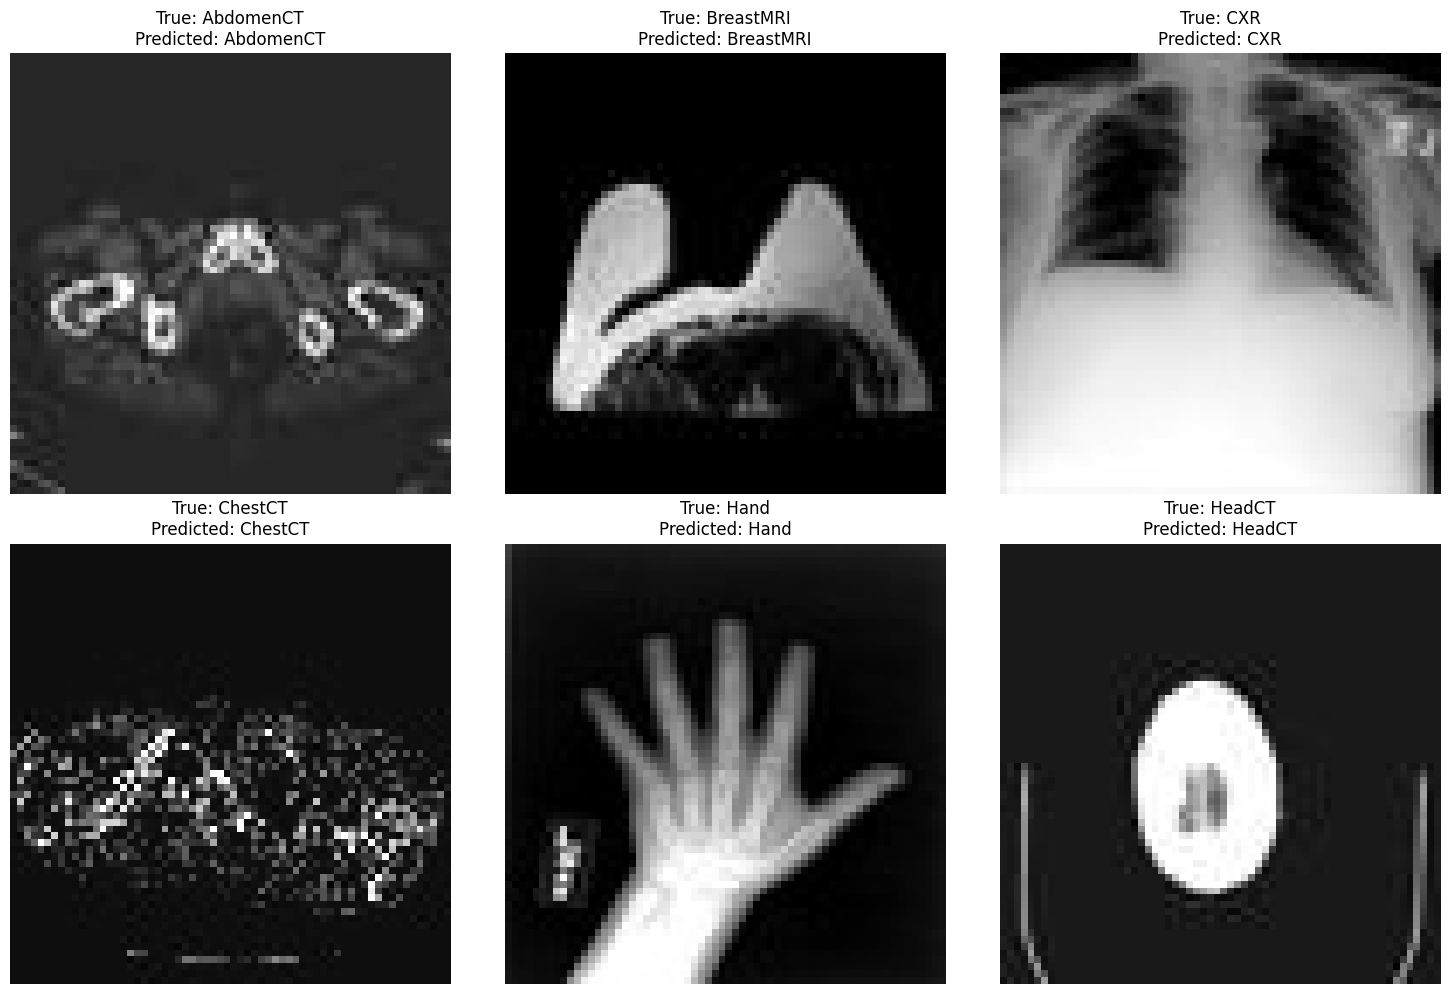

In [10]:
import random
plt.figure(figsize=(7.2, 2.4))
base_dir = path

classes = ["AbdomenCT", "BreastMRI", "CXR","ChestCT",  "Hand", "HeadCT"]

fig, axes = plt.subplots(2 ,3, figsize = (15, 10))

axes = axes.flatten()

for i, cls in enumerate(classes):
    class_dir = f"{base_dir}/{cls}"
    img_name = random.choice(os.listdir(class_dir))
    img_path = f"{class_dir}/{img_name}"

    # Load and preprocess the image
    img = load_img(img_path, target_size=(64, 64), color_mode='grayscale')
    img_array = img_to_array(img)  # Shape: (64, 64, 1)
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 64, 64, 1)
    img_array = img_array / 255.0  # Normalize

    # Get prediction from the model
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = classes[predicted_class]

    # Plot the image
    axes[i].imshow(img_array.squeeze(), cmap='gray')  # Remove extra dimension for display
    axes[i].set_title(f"True: {cls}\nPredicted: {predicted_label}")
    axes[i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()  